# Multicolor cell lineage: generative model
2023 Version, from 2017-2018 initial project
- genmodel_cellclass08.py

## Objective
- Generate synthetic microscopy data based on actual in vivo data
- Infer parameters underlying biological data based on synthetic data interpretation
- Determine viability of inferring lineage membership from in vivo data based on imaging alone

## To do
- add noise to cell color - doesn't work yet
- wrt getrandcolor():
    - maybe instead make some bins and have the function choose rgb values from those (minimize colors that are hard to distinguish)
        - will want to get random colors still actually but as with analysis code will want to be able to cluster them, and then put into the generative model only colors binned in the way that I want
    - maybe also want it to be possible to have some VZ cells be the same color to increase the number of cells without increasing the number of colors (function that does this would be nice)

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import scipy

from PIL import Image
import seaborn as sns; sns.set()

import random

#from sklearn.mixture import GMM
#from sklearn.preprocessing import MinMaxScaler
#from mpl_toolkits.mplot3d import Axes3D

Global variables

In [2]:
ylo = 0
yhi = 100
#for square image
xlo = ylo
xhi = yhi

stdev = 10
ydisplace = 60 #somewhat arbitrary
startcellno = 20

numdivisions = 12
colorchange = 10 #half the change of jittercolor

Initialize Cell class
- Each cell has properties x-location, y-location, color

In [3]:
class Cell:

    cellcount = 0
    #can't always trust that this will be the same as len(listcells)
    #at least while debugging
        
    def __init__(self, xloc, yloc, color):
        self.xloc = xloc
        self.yloc = yloc
        self.color = color
        Cell.cellcount += 1
        #will want to mask more than VZ to get age from real data

Function definitions

In [20]:
# randomly select a color for each cell lineage - could be improved
def getrandcolor():
    return (np.random.randint(60, 250), np.random.randint(60, 250), np.random.randint(60, 250))

# add some noise to daughter cell colors
def jittercolor(tup):
    newr = int(np.random.uniform(tup[0]-colorchange, tup[0]+colorchange))
    newg = int(np.random.uniform(tup[1]-colorchange, tup[1]+colorchange))
    newb = int(np.random.uniform(tup[2]-colorchange, tup[2]+colorchange))
    return (newr, newg, newb)

#choose the size of each cell and store it as an attribute for consistency
def choosesize():
    return np.random.randint(20,65)

#try using this for self.div of listcells[0,startcellno] - ?
def flip(p):
    return (random.random() < p)

# create daughter cells - revisit this implementation
def mitosis():
    morecells = []
    for i in range(0,startcellno):
        for j in range(0,numdivisions):
            newy = int(np.random.exponential(ydisplace))
            if newy < ylo: #try again if outside limits, if outside twice, then whatever
                newy = int(np.random.exponential(ydisplace))
            if newy > yhi:
                newy = int(np.random.exponential(ydisplace))
            yratio = (newy)/yhi
            newstdev = np.sqrt(10*yratio*(np.square(stdev)))
            newx = int(np.random.normal(loc=float(simplebio[i].xloc),scale=newstdev))
            #loc is the mean and scale is the stdev, takes in floats
            if newx < xlo: #try again if outside limits, if outside twice, then whatever
                newx = int(np.random.normal(loc=float(simplebio[i].xloc),scale=newstdev))
            if newx > xhi:
                newx = int(np.random.normal(loc=float(simplebio[i].xloc),scale=newstdev))
            #print("adding to simplebio[i]: " + str(i) + " x: " + str(newx) + " y: " + str(newy) + " color: " + str(simplebio[i].color))
            newcolor = jittercolor(simplebio[i].color)
            morecells.append(Cell(xloc = newx, yloc = newy, color = newcolor))
    return morecells

Create initial list of cells

In [21]:
# this is a simple biological model
simplebio =  [Cell(xloc = np.random.uniform(xlo,xhi),#changed this to uniform from randint
                   yloc = np.random.uniform(ylo,yhi),#changed this to uniform from randint
                  color = getrandcolor()) for i in range(startcellno)]

In [6]:
# check the attributes of individual cells                 
print(simplebio[0].__dict__)
print(simplebio[9].__dict__)
print(Cell.cellcount)

{'xloc': 97.1783678681739, 'yloc': 14.751816921298111, 'color': (126, 189, 83)}
{'xloc': 65.05382677475197, 'yloc': 36.33554244159682, 'color': (135, 211, 71)}
20


In [22]:
simplebio = mitosis()

In [8]:
# check total cell count after running mitosis
print(Cell.cellcount)

260


Visualize results

In [23]:
xs = []
ys = []
colors = []
    
for i in range(0,len(simplebio)):
    xs.append(simplebio[i].xloc)
    ys.append(simplebio[i].yloc)
    colors.append(simplebio[i].color)
    #something messes up here but otherwise works

#normalize rgb values to print on graph
normcolors = np.divide(colors,255)

In [24]:
normcolors

array([[0.54509804, 0.8       , 0.3254902 ],
       [0.56078431, 0.77647059, 0.30980392],
       [0.51372549, 0.80784314, 0.30980392],
       [0.50588235, 0.74901961, 0.36078431],
       [0.50588235, 0.74117647, 0.34117647],
       [0.54509804, 0.76470588, 0.32941176],
       [0.49019608, 0.74117647, 0.28627451],
       [0.50980392, 0.77254902, 0.3254902 ],
       [0.52941176, 0.75294118, 0.35686275],
       [0.49019608, 0.76862745, 0.29019608],
       [0.51764706, 0.8       , 0.29411765],
       [0.50588235, 0.78431373, 0.29803922],
       [0.48235294, 0.72156863, 0.35294118],
       [0.54117647, 0.7254902 , 0.34901961],
       [0.50196078, 0.69411765, 0.36862745],
       [0.54901961, 0.71764706, 0.37254902],
       [0.53333333, 0.67058824, 0.31372549],
       [0.53333333, 0.69803922, 0.3254902 ],
       [0.50196078, 0.68235294, 0.34117647],
       [0.51764706, 0.70588235, 0.34509804],
       [0.48627451, 0.7372549 , 0.3372549 ],
       [0.48235294, 0.72941176, 0.34117647],
       [0.

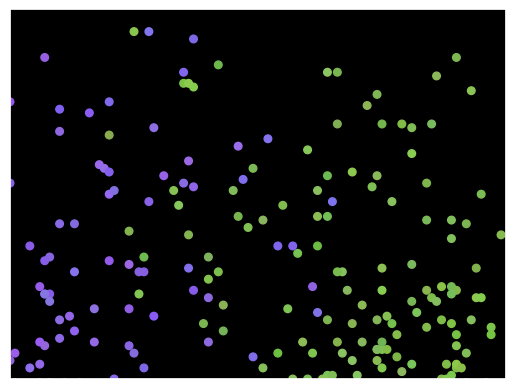

In [25]:
fig, ax = plt.subplots(1,1)#want to be able to change this
ax.scatter(xs, ys, c = normcolors, marker='o', s=30) #something here? c or color=normcolors?
ax.set_xlim([xlo+5,xhi+5])
ax.set_ylim([ylo+5,yhi+5])
ax.set_facecolor('black')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
#fig.savefig('4div_2stdev_20cells', dpi = 300)